In [69]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import warnings
warnings.simplefilter('ignore')

In [70]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "C:\\Users\\725191\\Desktop\\PepsiCo FSHA data\\Data extraction format\\generic_PDAF_Turgay_updated.xlsx"
#n_components = 0

# Text Normalization

In [71]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [72]:
fsha_data = pd.read_excel(filename)

In [73]:
fsha_data.head()

,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,Unnamed: 8,Unnamed: 9,...,baseProduct,prodModifications,newIngradient,approvedPackage,potentialMicrobial,cross_contactAllergens,chokeHazard,operationalAllergen,Unnamed: 44,Unnamed: 45
0,PRD - Reformulation Sweetcorn 10905989_IFF_SUA,46172,Cheetos Shots Sweetcorn / Cerezza TV Sweetcorn,Productivity,Reformulation of SweetCorn 10905989 seasoning ...,not provided,Zeynep Yolcu 0090 850 279 40 00,ESSA,NaN,NaN,...,No,No,Yes,No,Yes,Yes,No,Yes,NaN,NaN
1,PRD - Reformulation - SYM Peanut Flavour_Turkey,31989,Cheetos Peanut,Productivity,Reformulation of Peanut 355722 seasoning to dr...,not provided,Zeynep Yolcu 0090 850 279 40 00,ESSA,NaN,NaN,...,No,No,Yes,No,needs to be decided as to what value,needs to be decided as to what value,needs to be decided as to what value,Yes,NaN,NaN
2,Chipniks Commercialization at Awesome Snacks,NaN,Simba Chipniks,Capacity Expansion,Leveraging on Awesome Snacks extra fryer capac...,NaN,Sherwin Tlhoaele,ESSA,NaN,NaN,...,No,Yes,No,No,No,Yes,No,NaN,NaN,NaN
3,Crisp-mas 2018,50178,Walkers LTO christmas,Refresh,5 Christmas LTO's 3 x NPD 2 x L&S,christmas,Steve Wilson,ESSA,NaN,NaN,...,No,No,No,No,No,Yes,No,Yes,NaN,NaN
4,Simba Shapes Next Gen,36559,"Simba Shapes - Playz, Simba Shapes Twistz",Breakthrough - South Africa & Nigeria,Purchase an existing Pellet spec used by Pepsi...,unknown,Dina Atoyan (+7(495)9370550 (*63402) ),ESSA,NaN,NaN,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,NaN,NaN


In [74]:
fsha_data[['cookedOrHeated', 'specificStorage']]

,cookedOrHeated,specificStorage
0,no,no
1,no,no
2,Ready to eat snack,Do not store open product
3,no,no
4,No,Ambient Storage
5,No,Ambient Storage
6,No,"Yes, do not store after opening"
7,No,No
8,no,no
9,"NO, RTE",N/A ambient


# Categorical Label Standardization

In [75]:
#selecting set of columns for labelling
data2=fsha_data[['preservatives', ' pH', 'waterActivity', 'packaging',' otherFSA',
            'prod_storageDist', 'foodSafety_prodClaims',' targetMarket','allergens',' newIngradient','cookedOrHeated', 'specificStorage']]

#ph value label
data2['PH_label']=data2[' pH'].apply(lambda x:re.findall(r'[0-9]+', str(x)) if bool(re.search(r'\d', str(x))) else str(0))
def ph_process(x):
    if(len(x)>0):
        x = str(x[0])
    else:
        x = str(x)
    return x
data2['PH_label']=data2['PH_label'].apply(lambda x:ph_process(x))    
    

#'specificStorage'column label
def specificStorage(x):
    x=str(x.lower())
    #print(x)
    if x.__contains__('do not store'):
        return 'do not store open product'
    elif x.__contains__('ambient')  :
        return 'ambient storage'
    elif x.__contains__('no')  :
        return 'no'
    else:
        return 'NA'
data2['specificStorage_label']=data2['specificStorage'].apply(lambda x:specificStorage(x))    
#print(data2['specificStorage_label'])

#'cookedorHeated'column label
def cookedOrHeated(x):
    x=str(x.lower())
    #print(x)
    if x.__contains__('no'):
        return 'no'
    elif x.__contains__('ready to eat')  :
        return 'no'
    else:
        return 'NA'
data2['cookedOrHeated_label']=data2['cookedOrHeated'].apply(lambda x:cookedOrHeated(x))    
#print(data2['cookedOrHeated_label'])

#'prod_storageDist'column label
def prod_storageDist(x):
    x=str(x.lower())
    if x.__contains__('sun'):
            return 'Keep away from sun'
    elif x.__contains__('ambient')  :
              return 'ambient'
    elif x.__contains__('rte'):
        return 'RTE'
    else:
        return 'NA'
data2['prod_storageDist_label']=data2['prod_storageDist'].apply(lambda x:prod_storageDist(x))                                                              

#water activity
def water_activity(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('low'):
        return 'low'
    elif x.__contains__('max'):
        return 'max'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
data2['waterActivity_label']=data2['waterActivity'].apply(lambda x:water_activity(x))                                                              
 
#packaging'
def packaging(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('no') and x.__contains__('nitrogen'):
        return 'no nitrogen'
    elif x.__contains__('not') and x.__contains__('n2'):
        return 'no nitrogen'
    elif x.__contains__('nitrogen') and not x.__contains__('no'):
        return 'nitrogen'
    elif x.__contains__('atmosphere'):
        return 'atmosphere'
    elif x==str(np.nan):
        return 'NA'
    else:
        return(x)
    
data2['packaging_label']=data2['packaging'].apply(lambda x: packaging(x))  
  
#'preservatives'
def preservatives(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('sodium'):
        return 'Not used as preservatives'
    elif x.__contains__('not') and x.__contains__('seasoning'):
        return 'No Seasoning'
    elif bool(re.search('topping|seasoning',x)):
        return 'Used in seasoning'
    else:
        return ('NA')
    
data2['preservatives_label']=data2['preservatives'].apply(lambda x:preservatives(x))

#' otherFSA'
def otherFSA(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('moisture',x)):
        return 'Moisture'
    else:
        return 'NA'
data2['otherFSA_label']=data2[' otherFSA'].apply(lambda x:otherFSA(x))


def foodsafety_prodclaims(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('^claim',x)):
        return 'Claims Made'
    elif x.__contains__('no claims'):
        return 'No Claims Made'
    elif x.__contains__('allergen'):
        return 'Allergen'
    elif bool(re.search('none|n/a',x)):
        return 'NA'
    else:
        return(x)

data2['foodSafety_prodClaims_label']=data2['foodSafety_prodClaims'].apply(lambda x:foodsafety_prodclaims(x))  

#' targetMarket'
def targetMarket(x):
    x=str(x)
    x=x.lower()
    if (x.__contains__('choking') or x.__contains__('choke')) and x.__contains__('children'):
        return 'Choking hazard for children'
    elif x.__contains__('allerg'):
        return 'Allergy'
    elif x.__contains__('no') and x.__contains__('change'):
        return 'no'
    else:
        return(x)
data2['targetMarket_label']=data2[' targetMarket'].apply(lambda x:targetMarket(x))



In [23]:
#data2.columns

In [76]:
data2=data2.drop(['preservatives', ' pH', 'waterActivity', 'packaging',' otherFSA','prod_storageDist','foodSafety_prodClaims',' targetMarket','cookedOrHeated', 'specificStorage'],axis=1)


In [77]:
train_df = data2

In [78]:
train_df

,allergens,newIngradient,PH_label,specificStorage_label,cookedOrHeated_label,prod_storageDist_label,waterActivity_label,packaging_label,preservatives_label,otherFSA_label,foodSafety_prodClaims_label,targetMarket_label
0,Base allergens: None\nTop seasoning: Milk\nCro...,Yes,0,no,no,ambient,low,NA,Not used as preservatives,NA,no preservatives,no
1,"Base allergens: None\nTop seasoning: Milk, Glu...",Yes,0,no,no,ambient,low,NA,NA,NA,no preservatives,no
2,Wheat Gluten,No,0,do not store open product,no,ambient,NA,no nitrogen,NA,NA,No Claims Made,Choking hazard for children
3,"milk, Soya, Barley",No,3,no,no,NA,max,atmosphere,No Seasoning,NA,NA,no
4,Inherent:\nCheddar Playz: Cereals containing G...,Yes,0,ambient storage,no,ambient,"pellet (<0.6), finished product (<0.15)",nitrogen,NA,Moisture,NA,Choking hazard for children
5,Pellets Inherent:\nCereals containing Gluten -...,Yes,0,ambient storage,no,ambient,"pellet (<0.6), finished product (<0.15)",no nitrogen,NA,Moisture,NA,Choking hazard for children
6,Standard allergen management for Seasoning. Th...,No,0,do not store open product,no,RTE,low,nitrogen,NA,NA,NA,no
7,Allergens in seasonings:\nCQ69 Vegetable Blend...,Yes,0,no,no,Keep away from sun,low,atmosphere,NA,NA,Claims Made,Allergy
8,Inherent\n\nParmesan Cheese & Roasted Garlic B...,Yes,0,no,no,ambient,low,nitrogen,Not used as preservatives,NA,50% less fat comparing to fried potato chips,no
9,"Inherent - Wheat, Gluten, Sulphites, Soya, Mil...",Yes,0,ambient storage,no,ambient,low,packaging conditions tbc,Used in seasoning,NA,Allergen,Allergy


In [11]:
def categorical_encode(data):
    values = array(data)
    #print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(integer_encoded)
    return integer_encoded
    """
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print(onehot_encoded)
    return onehot_encoded
    """

In [79]:
whiten = False
random_state = 42
svd_solver="full"

In [80]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE = ngram_range_inp

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    #x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    #selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    #selector.fit(x_train, train_labels)
    #x_train = selector.transform(x_train)
    #x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    #x_val = x_val.astype('float32')
    return x_train

# Text normalization

In [81]:
def preprocess_text(train_df,y,n_comp,n_gram_range):

    train_df['preservatives_label'] = train_df['preservatives_label'].astype('category').cat.codes
    train_df['prod_storageDist_label'] = train_df['prod_storageDist_label'].astype('category').cat.codes
    train_df['waterActivity_label'] = train_df['waterActivity_label'].astype('category').cat.codes
    train_df['packaging_label'] = train_df['packaging_label'].astype('category').cat.codes
    train_df['otherFSA_label'] = train_df['otherFSA_label'].astype('category').cat.codes
    train_df['prod_storageDist_label'] = train_df['prod_storageDist_label'].astype('category').cat.codes
    train_df['foodSafety_prodClaims_label'] = train_df['foodSafety_prodClaims_label'].astype('category').cat.codes
    train_df['targetMarket_label'] = train_df['targetMarket_label'].astype('category').cat.codes
    train_df[' newIngradient'] = train_df[' newIngradient'].astype('category').cat.codes
    train_df['PH_label'] = train_df['PH_label'].astype('category').cat.codes
    train_df['cookedOrHeated_label'] = train_df['cookedOrHeated_label'].astype('category').cat.codes
    train_df['specificStorage_label'] = train_df['specificStorage_label'].astype('category').cat.codes
    #print(train_df['specificStorage_label'])
    norm_allergens = normalize_corpus(train_df['allergens'])
    train_df = train_df.drop(['allergens'],axis=1)
    print(train_df.shape)
    train_labels = y
    x_train = ngram_vectorize(norm_allergens, train_labels,n_gram_range)
    x_train=x_train.toarray()
    print(x_train.shape)
    
    if (n_comp > 0):
        pca = PCA(n_components=n_comp,svd_solver=svd_solver,whiten=whiten, random_state=42)
        x_pca = pca.fit_transform(x_train)
        x_train = np.concatenate((train_df,x_pca),axis=1)
    else:
        x_train = np.concatenate((train_df,x_train),axis=1)
    print(x_train.shape)
    return x_train

In [82]:
train_y=[]
for i in range (len(fsha_data)):
    if fsha_data["potentialMicrobial"][i] =='Yes':
        train_y.append(1)
    else:
        train_y.append(0)

In [83]:
y = train_y

In [206]:
n_components=3
x_train = preprocess_text(train_df,y,n_components,ngram_range_inp)
x_train.shape

(10, 11)
(10, 51)
(10, 14)


(10, 14)

In [207]:
x_train[0]

array([ 1.        ,  0.        ,  2.        ,  0.        ,  3.        ,
        1.        ,  0.        ,  2.        ,  1.        ,  5.        ,
        2.        ,  0.6332597 ,  0.03527156, -0.225717  ], dtype=float32)

In [208]:
y

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

# Choosing optimal cutoff probability

In [87]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [153]:
from datetime import datetime
import time
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(len(X_train))
    
    clf_descr = str(clf).split('(')[0]
    print("model name:"+clf_descr)
  
    a = datetime.now()
    #a = int(round(time.time() * 1000))
    
    if clf_descr.__contains__('tensorflow'):
        history = clf.fit(
            X_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_test, y_test),
            verbose=2, 
            batch_size=batch_size)
    else:
        clf.fit(X_train, y_train)
    
    #b = int(round(time.time() * 1000))
    b = datetime.now()
    c = a-b
    train_time = c.microseconds
    print("train time: %0.3fs" % train_time)

    pred = clf.predict(X_test)
    
    pred_train = clf.predict(X_train)
 
    if clf_descr.__contains__('tensorflow'):
        threshold = Find_Optimal_Cutoff(y_test, pred)
        for i in range (len(pred)):
            if (pred[i]>=threshold):
                pred[i]=1
            else:
                pred[i]=0
        for i in range (len(pred_train)):        
            if (pred_train[i]>=threshold):
                pred_train[i]=1
            else:
                pred_train[i]=0
    
    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score )
    
    f1_score_train = metrics.f1_score(y_train, pred_train)
    print("f1_score_train:   %0.3f" % f1_score_train )
    
    print("classification report:")
    print(classification_report(y_test, pred))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    
    return clf_descr,f1_score_train,f1_score,train_time

In [209]:
X, y = x_train,y

In [210]:
K = pd.DataFrame(X)

In [211]:
K.shape

(10, 14)

In [212]:
K.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,0.0,2.0,0.0,3.0,1.0,0.0,2.0,1.0,5.0,2.0,0.633260,0.035272,-0.225717
1,1.0,0.0,2.0,0.0,3.0,1.0,0.0,0.0,1.0,5.0,2.0,0.655567,-0.018699,-0.156332
2,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,4.0,1.0,-0.208822,0.622160,0.280228
3,0.0,1.0,2.0,0.0,1.0,2.0,1.0,1.0,1.0,3.0,2.0,0.093213,-0.322204,-0.291790
4,1.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,0.0,3.0,1.0,-0.395580,-0.486307,-0.092783


# Change the sample size from here

In [213]:
from scipy import signal
import random
def generate_samples(sampleSize):
    for i in range(len(list(K))):
        x = K.iloc[:,i].astype(int)
        if i == 0:
            f = pd.Series(signal.resample(x, sampleSize))
        else:
            f = pd.concat([f, pd.Series(signal.resample(x,sampleSize))],axis=1)
    f.columns = list(X)

    y=[]
    for i in range(0,sampleSize):
        y.append(random.choices([0,1]))
        
    return f,y


In [250]:
X,y = generate_samples(2000)
X.shape

(2000, 14)

In [251]:
selector = SelectKBest(f_classif, k='all')

y = np.array(y)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

#print(y_test)

(1600, 14)
(400, 14)


In [252]:
results = []
model_name = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    selector_clf = benchmark(Pipeline([('selector', selector),('classifier', clf)]))
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    model_name.append(name)
    #model.append(clf)
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,dual=False, tol=1e-3)))
    model_name.append("LinearSVC"+" "+penalty)

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty=penalty)))
    model_name.append("SGDClassifier"+" "+penalty)


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")))
model_name.append("SGD with Elastic Net penalty")


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))
model_name.append("NearestCentroid (aka Rocchio classifier)")


________________________________________________________________________________
Training: 
1600
model name:Pipeline
train time: 995000.000s
f1_score:   0.427
f1_score_train:   0.481
classification report:
             precision    recall  f1-score   support

          0       0.47      0.60      0.53       192
          1       0.50      0.37      0.43       208

avg / total       0.49      0.48      0.48       400

confusion matrix:
[[116  76]
 [131  77]]
Ridge Classifier
________________________________________________________________________________
Training: 
1600
model name:RidgeClassifier
train time: 996000.000s
f1_score:   0.427
f1_score_train:   0.481
classification report:
             precision    recall  f1-score   support

          0       0.47      0.60      0.53       192
          1       0.50      0.37      0.43       208

avg / total       0.49      0.48      0.48       400

confusion matrix:
[[116  76]
 [131  77]]
dimensionality: 14
density: 0.714286
_______________

In [253]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout


def mlp_model(layers, units, dropout_rate, input_shape):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.

    # Returns
        An MLP model instance.
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [254]:
X.shape[1:]

(14,)

In [255]:
learning_rate=1e-3
epochs=100
batch_size=128
layers=5
units=64
dropout_rate=0.2
model = mlp_model(layers=layers,units=units,dropout_rate=dropout_rate,input_shape=X.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_61 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)                960       
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_63 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_64 (Dropout)         (None, 64)                0         
__________

In [256]:
# Train NearestCentroid without threshold
print('=' * 80)
print("Keras Dense Neural Network")
results.append(benchmark(model))
model_name.append("Keras Dense Neural Network")

Keras Dense Neural Network
________________________________________________________________________________
Training: 
1600
model name:<tensorflow.python.keras.engine.sequential.Sequential object at 0x000000002F460080>
Train on 1600 samples, validate on 400 samples
Epoch 1/100
 - 1s - loss: 0.6960 - acc: 0.4925 - val_loss: 0.6953 - val_acc: 0.4825
Epoch 2/100
 - 0s - loss: 0.6977 - acc: 0.4894 - val_loss: 0.6937 - val_acc: 0.4975
Epoch 3/100
 - 0s - loss: 0.6949 - acc: 0.5056 - val_loss: 0.6945 - val_acc: 0.4900
Epoch 4/100
 - 0s - loss: 0.6938 - acc: 0.5063 - val_loss: 0.6942 - val_acc: 0.4950
Epoch 5/100
 - 0s - loss: 0.6969 - acc: 0.4969 - val_loss: 0.6957 - val_acc: 0.4950
train time: 890000.000s
f1_score:   0.504
f1_score_train:   0.544
classification report:
             precision    recall  f1-score   support

          0       0.48      0.51      0.49       192
          1       0.52      0.49      0.50       208

avg / total       0.50      0.50      0.50       400

confusion 

# Displaying the threshold probability

In [257]:
pred = model.predict(X_test)
threshold = Find_Optimal_Cutoff(y_test, pred)
print(threshold)

[0.49534812569618225]


In [258]:
# make some plots
print(len(results))

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, f1_score_train, f1_score_test, training_time = results
print(f1_score_train)
print(f1_score_test)
print(training_time)
print(model_name)

12
[0.48140350877192983, 0.42483171278982795, 0.41600000000000004, 0.6772486772486772, 1.0, 0.4842249657064472, 0.5657964837506659, 0.4842681258549932, 0.5227817745803358, 0.5244667503136763, 0.5065616797900262, 0.5435582822085888]
[0.42659279778393355, 0.3630952380952381, 0.4359673024523161, 0.48000000000000004, 0.47665847665847666, 0.43454038997214484, 0.5750528541226215, 0.43454038997214484, 0.536036036036036, 0.47058823529411764, 0.44919786096256686, 0.5037037037037037]
[996000, 993000, 989000, 998000, 532000, 997000, 992000, 991000, 984000, 984000, 0, 890000]
['Ridge Classifier', 'Perceptron', 'Passive-Aggressive', 'kNN', 'Random forest', 'LinearSVC l2', 'SGDClassifier l2', 'LinearSVC l1', 'SGDClassifier l1', 'SGD with Elastic Net penalty', 'NearestCentroid (aka Rocchio classifier)', 'Keras Dense Neural Network']


In [259]:
training_time = np.array(training_time) / np.max(training_time)
print(training_time)

[0.99799599 0.99498998 0.99098196 1.         0.53306613 0.998998
 0.99398798 0.99298597 0.98597194 0.98597194 0.         0.89178357]


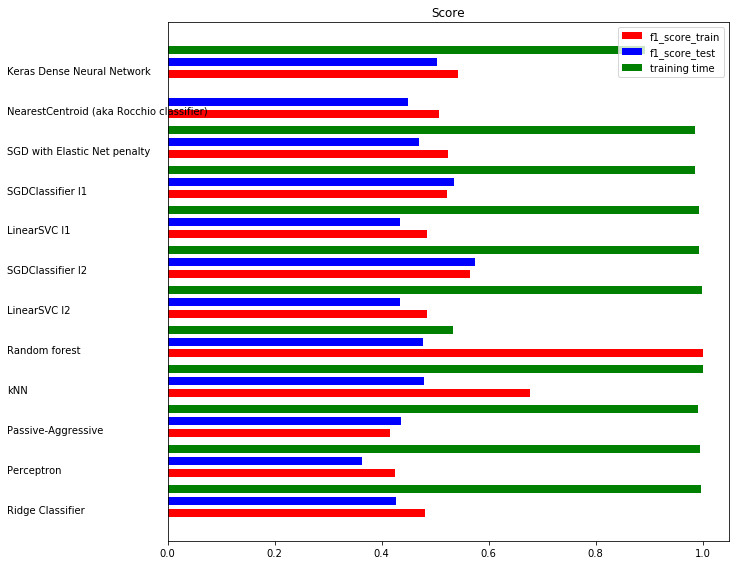

In [260]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, f1_score_train, .2, label="f1_score_train", color='r')
plt.barh(indices+0.3, f1_score_test, .2, label="f1_score_test", color='b')
plt.barh(indices + .6, training_time, .2, label="training time", color='g')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, model_name):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
"""
# Train sparse Naive Bayes classifiers

if (n_components==0):
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01)))
    model_name.append("MultinomialNB")
    accuracy.append(accuracy)
    f1_score.append(f1_score)



results.append(benchmark(BernoulliNB(alpha=.01)))
model_name.append("BernoulliNB")
accuracy.append(accuracy)
f1_score.append(f1_score)     
"""


In [281]:
from matplotlib import pyplot as plt
plt.savefig('D:\\Pepsico\\f1score2000.jpeg',bbox_inches = 'tight')
plt.close()

# Saving the model and loading the model with best F1-score

In [225]:
index100=np.argmax(f1_score_test)
print(index100)
f1score100 = f1_score_test[index100]
print(f1score100)
print(model_name[index100])

10
0.75
NearestCentroid (aka Rocchio classifier)


In [237]:
index500=np.argmax(f1_score_test)
f1score500 = f1_score_test[index500]
print(f1score500)
print(model_name[index500])

0.5811965811965811
LinearSVC l1


In [249]:
index1000=np.argmax(f1_score_test)
f1score1000 = f1_score_test[index1000]
print(f1score1000)
print(model_name[index1000])

0.6277372262773723
Perceptron


In [261]:
index2000=np.argmax(f1_score_test)
f1score2000 = f1_score_test[index2000]
print(f1score2000)
print(model_name[index2000])

0.5750528541226215
SGDClassifier l2


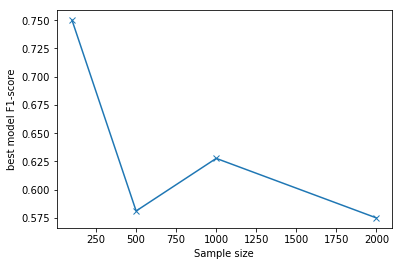

In [262]:
##Plotting the best model f1-scores

import matplotlib.pyplot as plt
plt.plot([100, 500, 1000, 2000],[f1score100,f1score500,f1score1000,f1score2000],marker="x")
#plt.xlim([0,2000])
plt.ylabel('best model F1-score')
plt.xlabel('Sample size')
plt.show()

In [534]:
#model_name

In [535]:
#model

In [263]:
print("Best classifier is:"+model_name[index100],"||f1_score",f1score100)
print("Best classifier is:"+model_name[index500],"||f1_score",f1score500)
print("Best classifier is:"+model_name[index1000],"||f1_score",f1score1000)
print("Best classifier is:"+model_name[index2000],"||f1_score",f1score2000)

Best classifier is:NearestCentroid (aka Rocchio classifier) ||f1_score 0.75
Best classifier is:LinearSVC l1 ||f1_score 0.5811965811965811
Best classifier is:Perceptron ||f1_score 0.6277372262773723
Best classifier is:SGDClassifier l2 ||f1_score 0.5750528541226215
